In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.utils as ku 
import pickle

print(tf.keras.__version__)
tf.test.gpu_device_name()

2022-12-29 13:16:45.615930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


2022-12-29 13:16:49.869189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 13:16:50.168536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 13:16:50.189864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 13:16:50.190169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_nod

'/device:GPU:0'

In [2]:
#!pip install pandas
#!pip install --timeout=10000 matplotlib
#!pip install pydot
#!pip install tensorflow-text

In [18]:
def add_spaces(x):
    return " ".join(x)

# We load the list, add a space between each letter and add an EOP (End of Passwort) Symbol pp. Since this is the only 2 letter "word" the EOP is unique.
def transform_password(df_in: pd.DataFrame) -> pd.DataFrame:
    return df_in[0].dropna().apply(lambda x: add_spaces(x) + ' eof' )
    
try:
    with open('data.pkl', 'rb') as file:
        df = pickle.load(file)
except:
    # Load the Password list into Memory
    url = "https://raw.githubusercontent.com/danielmiessler/SecLists/master/Passwords/Common-Credentials/10-million-password-list-top-1000000.txt"

    df_in = pd.read_csv(url, header=None)

    df = transform_password(df_in)
    with open('data.pkl', 'wb') as file:
        # Cache Data
        pickle.dump(df, file)


In [4]:
# We generate the observed sequence and the next word to be predicted (target).
# ToDo: Need to exclude last letter
sequences = []
#target =[]
for row in df:#[:20_000]:   #200000
    i=-1
    row_sequences = []
    for letter in row.split():
        if i>=0:
            if i>0:
                row_sequences.append(row_sequences_dummy + [letter] )
            row_sequences_dummy = row_sequences_dummy + [letter]
            #target.append([letter])
        else:
            row_sequences_dummy=[letter]
        i=i+1
    sequences.append(row_sequences)
sequences = [num for elem in sequences for num in elem]

#This approach may allow the model to use the context of each line to help the model in those cases where a simple one-word-in-and-out model creates ambiguity.

In [5]:
from keras.preprocessing.text import Tokenizer

#We us a Tokenizer to code each Letter into a number

tokenizer  = Tokenizer(filters=None, char_level=True, lower=False)
tokenizer.fit_on_texts(sequences)

# Translation from Word to Token and back
word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
vocab_size = len(word2idx) + 1

In [6]:
# The one hot matrix is nice, but we don't need that
#1. get max password length

max_length = max([len(x) for x in sequences])

In [7]:
def pad_and_tokenize(sequences, tokenizer, max_length):
    return tf.keras.preprocessing.sequence.pad_sequences( tokenizer.texts_to_sequences(sequences) , maxlen = max_length, padding='pre')

tok_sequence = pad_and_tokenize(sequences, tokenizer, max_length)

In [8]:
# Split the Data into X and y

predictors, label = tok_sequence[:,:-1], tok_sequence[:,-1]
label = ku.to_categorical(label, num_classes=vocab_size)

In [9]:
print(predictors.shape)
print(label.shape)
X_train=predictors
y_train=label

(6529103, 39)
(6529103, 96)


In [10]:
class PasswordBatchGenerator(ku.Sequence) :
  
  def __init__(self, X_train, labels, batch_size) :
    self.X_train = X_train
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(self.X_train.shape[0] / float(self.batch_size))).astype(np.int32)
  
  
  def __getitem__(self, idx) :
    batch_x = self.X_train[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return (batch_x,batch_y)

In [11]:
# Garbage collector
try:
    del df_in
    del sequences
    del df
except:
    pass

# Init generator
batch_size= 10_000
training_batch = PasswordBatchGenerator(X_train, y_train, batch_size)

In [12]:

# https://stackoverflow.com/questions/43341374/tensorflow-dynamic-rnn-lstm-how-to-format-input
# https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html
# https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275
# https://ai.stackexchange.com/questions/18198/what-is-the-difference-between-lstm-and-rnn#:~:text=The%20main%20difference%20between%20an%20LSTM%20unit%20and,better%20the%20flow%20of%20information%20through%20the%20unit.

try:
  with open('/root/model.pkl', 'rb') as file:
      model = pickle.load(file)
except:
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 10, input_length=max_length-1), #Turns positive integers (indexes) into dense vectors of fixed size.
    tf.keras.layers.Masking(mask_value=0),
    # tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100), # skips masked timesteps
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  model.compile(
    #optimizer='rmsprop',
                loss='categorical_crossentropy',
                optimizer='adam')

  # model.fit( X_train , y_train, epochs=10, verbose=1, batch_size=10_000)    # I am not sure if my fitting here works, my code does not make it here

  # big data needs a generator
  model.fit( training_batch , epochs=100, verbose=1)



2022-12-29 13:17:56.661778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 13:17:56.662944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 13:17:56.664121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 13:17:56.667116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 13:17:56.667761: I tensorflow/compile

Epoch 1/100


2022-12-29 13:18:02.980008: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2022-12-29 13:18:05.156621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-29 13:18:07.318494: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe7a000ffe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-29 13:18:07.319454: I tensorflow/compiler/

653/653 [==============================] - 148s 210ms/step - loss: 3.3018
Epoch 2/100
653/653 [==============================] - 136s 208ms/step - loss: 2.9517
Epoch 3/100
653/653 [==============================] - 134s 205ms/step - loss: 2.9078
Epoch 4/100
653/653 [==============================] - 135s 206ms/step - loss: 2.8801
Epoch 5/100
653/653 [==============================] - 134s 205ms/step - loss: 2.8561
Epoch 6/100
653/653 [==============================] - 134s 205ms/step - loss: 2.8315
Epoch 7/100
653/653 [==============================] - 134s 205ms/step - loss: 2.8085
Epoch 8/100
653/653 [==============================] - 134s 205ms/step - loss: 2.7899
Epoch 9/100
653/653 [==============================] - 134s 205ms/step - loss: 2.7717
Epoch 10/100
653/653 [==============================] - 134s 205ms/step - loss: 2.7577
Epoch 11/100
653/653 [==============================] - 134s 205ms/step - loss: 2.7449
Epoch 12/100
653/653 [==============================] - 132s 202

In [13]:
import pickle

# pickle model
with open('/root/model.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(model, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......masking
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2022-12-29 17:02:40           64
config.json                                    2022-12-29 17:02:40         2454
variables.h5                                   2022-12-29 17:02:40       687008


In [16]:
from keras import Sequential
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

def plt_props(vals, preds):
    f = plt.figure()
    f.set_figwidth(20)
    plt.bar(vals, preds, width=0.9)
    plt.show()

def predict_letter(vocabular:list, propabilities:list, plot:bool=False)->dict:
    """Performs a random choice out of the vocabular based on the passed propabilities."""
    if plot:
        plt_props(vocabular, propabilities[0])
    return np.random.choice( vocabular , 1, p=propabilities[0])[0]

def predict_next_letter(previous_letters: str, model: Sequential, tokenizer: Tokenizer, plot:bool=False ) -> str:
    max_length = model.get_config()["layers"][0]["config"]["batch_input_shape"][1]
    previous_letters = list(map(add_spaces, [previous_letters]))
    tok_prev = pad_and_tokenize(previous_letters, tokenizer, max_length)
    propabilities = model.predict(tok_prev)
    predicted_letter = predict_letter(['eof'] + list(tokenizer.index_word.values()) , list(propabilities), plot)
    return predicted_letter


def predict_password(previous_letters: str, model: Sequential, tokenizer: Tokenizer) -> str:
    password = previous_letters
    new_letter=""
    while True:
        new_letter = predict_next_letter(password, model, tokenizer)
        if new_letter == "eof":
            break
        password = password + new_letter
    return password

1/1 [==============================] - 0s 38ms/step


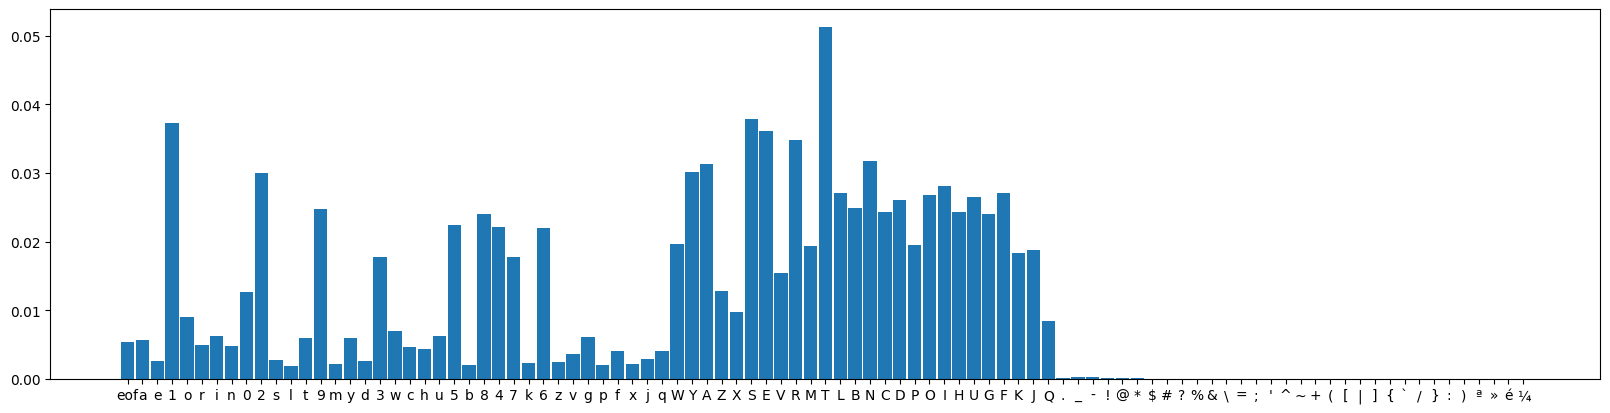

1/1 [==============================] - 0s 32ms/step


'FGD620Ku'

In [38]:
predict_next_letter("FGD", model, tokenizer, True)

predict_password("FGD", model, tokenizer )

In [ ]:
# As a benchmark we will train a simple feed foreward newtwork. This Network corresponds to the markov chain approach described here. We use the the current letter as input to try to predict the next letter. Apart from this, the model does not use any sequencial or positional informations. 
# Next, we need to create sequences of words to train the model with one word as input and one word as output.

In [ ]:
#https://jhui.github.io/2017/03/15/RNN-LSTM-GRU/
#https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn
#https://www.kaggle.com/code/namansood/nlp-guide-next-word-prediction-and-deep-learning

In [ ]:
For what you're asking, I don't think a Bidirectional network would be good. (The reverse direction would be trying to predict something that does not appear at the end, but before the beginning, and I believe you're going to want to take the output and make it an input and keep predicting further, right?)

So, first, remove the Bidirectional from your model, keep only the LSTM.

Keras recurrent layers may output only the last step, or, if you set return_sequences=True, output all steps.

So, the trick is adjusting both the data and the model like this:

    In the LSTM layers, add return_sequences=True. (Your output will be entire sentences)
    Make Y be entire sentences one step ahead of X: X,y = sequences[:,:-1], sequences[:,1:] 

Just be aware that this will make your output 3D. If you're interested only in the last word, you can manually take it from the output: lastWord = outputs[:,-1]

SyntaxError: invalid syntax (3504721098.py, line 1)